# vae

> A simple VAE implementation in PyTorch heavily inspired by [Variational Autoencoder (VAE) — PyTorch Tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f) and its accompanying [collab notebook](https://colab.research.google.com/gist/rekalantar/2c303b69a11875dfba873aac11e44cfd/variationalautoencoder_pytorch.ipynb).

In [ ]:
import os

In [ ]:
import lightning as pl

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torchvision.datasets import MNIST

In [ ]:
# Download datasets
ds_path = os.path.abspath("datasets")
os.makedirs(ds_path, exist_ok=True)


In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, ds_path: str, batch_size=32, random_seed=42):
        super().__init__()
        self.ds_path = ds_path
        self.batch_size = batch_size
        self.random_seed = random_seed

    def prepare_data(self):
        # Download datasets
        transform = transforms.Compose([transforms.ToTensor()])

        self.orig_train_dataset = MNIST(self.ds_path, transform=transform, download=True, train=True)
        self.test_dataset  = MNIST(self.ds_path, transform=transform, download=True, train=False)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        total_size = len(self.orig_train_dataset)
        train_size = int(0.9 * total_size)
        val_size = total_size - train_size

        gen = torch.Generator()
        gen.manual_seed(self.random_seed)
        if stage == 'fit' or stage is None:
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(self.orig_train_dataset, [train_size, val_size], generator=gen)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
dm = MNISTDataModule(ds_path, batch_size=32)
dm.prepare_data()
dm.setup()

In [ ]:
train_loader = dm.train_dataloader()
batch = next(iter(train_loader))


In [ ]:
batch[0].shape, batch[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

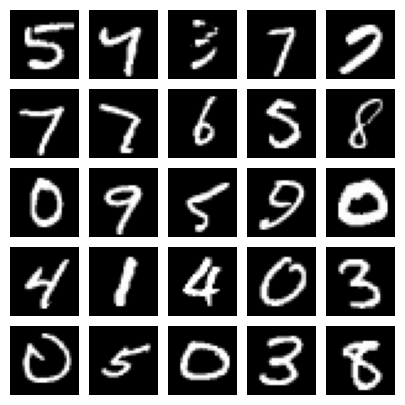

In [ ]:
num_samples = 25
batch_images = batch[0]
sample_images = batch_images[:num_samples, 0]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(mean)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [ ]:
class VAEModule(pl.LightningModule):
    def __init__(self, model: VAE, lr: float = 1e-3):
        super().__init__()
        self.model = model
        self.lr = lr

        self.loss = nn.BCELoss(reduction='sum')

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat, mean, log_var = self(x)

        recon_loss = self.loss(x_hat, x)
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        loss = recon_loss + kl_div
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Train model
model = VAE()
vae = VAEModule(model)

trainer = pl.Trainer(max_epochs=10)
trainer.fit(vae, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | VAE     | 790 K 
1 | loss  | BCELoss | 0     
----------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.162     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/spather/code/ai-learning/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/spather/code/ai-learning/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
def generate_digit(mean, var):
    z_sample = vae.model.reparameterization(mean, var).unsqueeze(0).to(vae.device)
    x_decoded = vae.model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

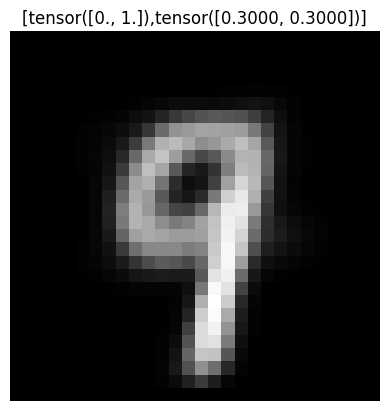

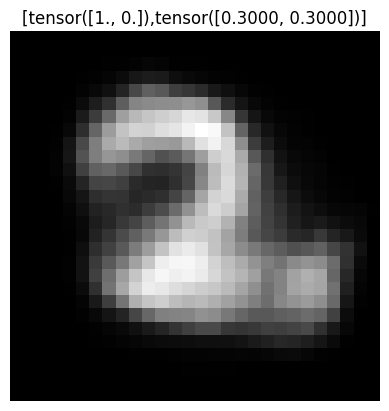

In [ ]:
torch.manual_seed(42)
generate_digit(torch.tensor([0.0, 1.0]), torch.tensor([0.3, 0.3])),
generate_digit(torch.tensor([1.0, 0.0]), torch.tensor([0.3, 0.3]))

In [ ]:
def plot_latent_space(model, device: str, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

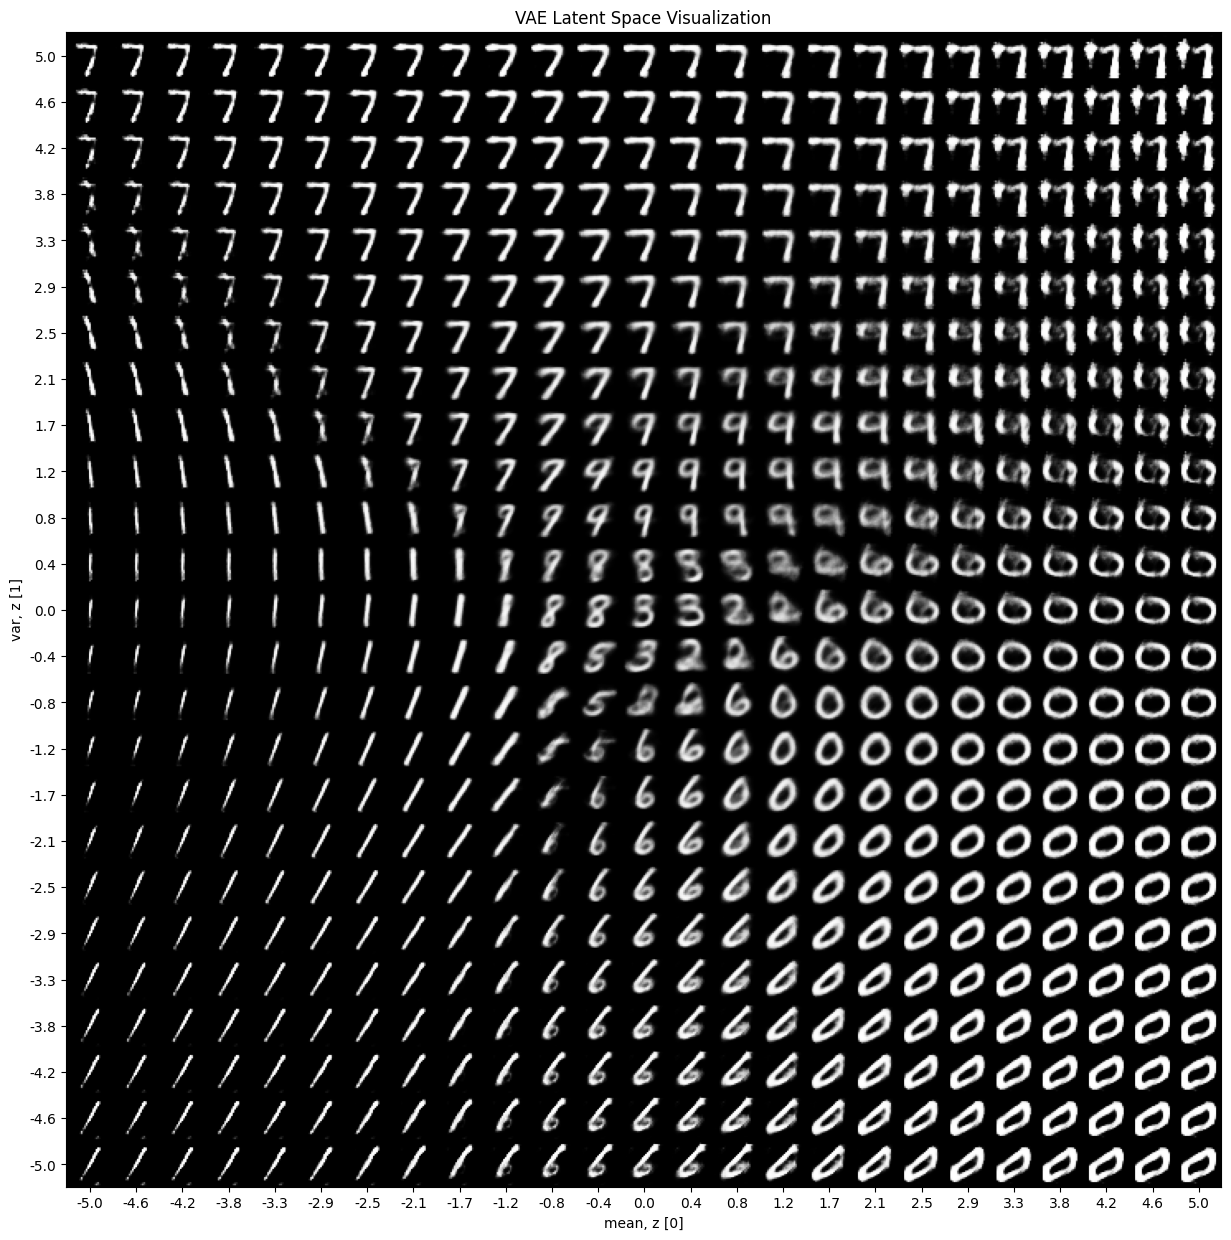

In [ ]:
plot_latent_space(vae.model, vae.device, scale=5.0, n=25, digit_size=28, figsize=15)